# [Explaining and Harnessing Adversarial Examples](http://arxiv.org/abs/1412.6572)

This paper has three main contributions: 

- We argue that the primary cause of neural networks’ vulnerability to adversarial perturbation is their **linear nature**.
- This view yields a simple and fast method of **generating adversarial examples**. Using this approach to provide examples for adversarial training, we reduce the test set error of a maxout network on the MNIST dataset.
- We show that **adversarial training** can provide an additional regularization benefit beyond that provided by using dropout alone. Generic regularization strategies such as dropout, pretraining, and model averaging do not confer a significant reduction in a model’s vulnerability to adversarial examples, but changing to nonlinear model families such as RBF networks can do so.

Our explanation suggests a fundamental tension between **designing models that are easy to train due to their linearity** and **designing models that use nonlinear effects to resist adversarial perturbation**. In the long run, it may be possible to escape this tradeoff by designing more powerful optimization methods that can succesfully train more nonlinear models.

This explanation is supported by new quantitative results while giving the first explanation of the most intriguing fact about them: their generalization across architectures and training sets. 

A popular approach in computer vision is to use convolutional network features as a space where Euclidean distance approximates perceptual distance. This resemblance is clearly flawed if images that have **an immeasurably small perceptual distance** correspond to **completely different classes** in the network’s representation.


## THE LINEAR EXPLANATION OF ADVERSARIAL EXAMPLES

We start with explaining the existence of adversarial examples for linear models.

Formally, for problems with well-separated classes, we expect the classifier to assign the same class to $x$ and  $\tilde{x} = x + η$  so long as  $||η||_{∞} < \epsilon$, where $\epsilon$ is small enough to be discarded by the sensor or data storage apparatus associated with our problem.

Consider the dot product between a weight vector $w$ and an adversarial example $\tilde{x}$:
$$
w^{T} \tilde{x} = w^{T} x + w^{T}η
$$

We can maximize this increase subject to the max norm constraint on $η$ by assigning $η$ = sign($w$).

If $w$ has $n$ dimensions and the average magnitude of an element of the weight vector is $m$, then the activation will grow by $\epsilon mn$.

Since $||η||_{∞}$ does not grow with the dimensionality of the problem but the change in activation caused by perturbation by $η$ can grow linearly with $n$, then for **high dimensional** problems, we can make many infinitesimal changes to the input that add up to one large change to the output. 

We can think of this as a sort of “accidental steganography,” where a linear model is forced to attend exclusively to the signal that aligns most closely with its weights, even if multiple signals are present and other signals have much greater amplitude.

This explanation shows that a simple linear model can have adversarial examples if its input has sufficient dimensionality. Our hypothesis based on linearity is simpler, and can also explain why softmax regression is vulnerable to adversarial examples.

## LINEAR PERTURBATION OF NON-LINEAR MODELS

Let $θ$ be the parameters of a model, $x$ the input to the model, $y$ the targets associated with $x$ (for machine learning tasks that have targets) and $J(θ, x, y)$ be the cost used to train the neural network. We can linearize the cost function around the current value of $θ$ , obtaining an optimal max-norm constrained pertubation of

$$
η = \epsilon sign (∇_{x}J(θ, x, y))
$$

We refer to this as the “**fast gradient sign method**” of generating adversarial examples. Note that the required gradient can be computed efficiently using backpropagation.

In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

use_cuda = True

In [2]:
eps_1 = 0.007

In [3]:
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [4]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

def image_folder_custom_label(root, transform, custom_label) :

    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(custom_label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = custom_label
    new_data.class_to_idx = label2idx

    return new_data

In [5]:
normal_data = image_folder_custom_label(root = './data/', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


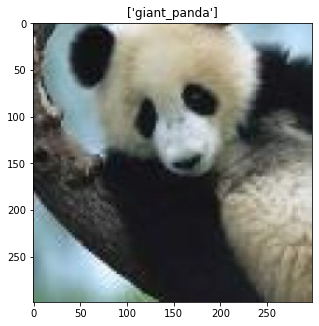

In [7]:
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

In [8]:
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
model_1 = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT).to(device)
# model_1 = models.googlenet(pretrained=True).to(device)

True Image & Predicted Label


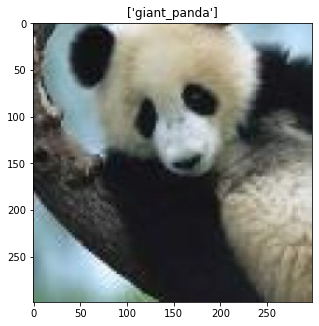

83.370739 % confidence
Accuracy of test text: 100.000000 %


In [10]:
print("True Image & Predicted Label")

model_1.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_1(images)

    outputs = nn.functional.softmax(outputs, dim=1)
    
    con, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    print('%f %% confidence' % (con.item()*100))
        
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

In [11]:
def fgsm_attack(model, loss, images, labels, eps) :
    
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
            
    outputs = model(images)
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

In [12]:
loss = nn.CrossEntropyLoss()

Attack Image & Predicted Label


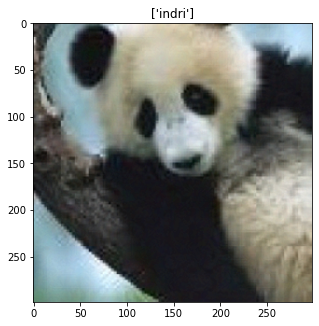

73.568529 % confidence
Accuracy of test text: 0.000000 %


In [13]:
print("Attack Image & Predicted Label")

model_1.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = fgsm_attack(model_1, loss, images, labels, eps_1).to(device)
    labels = labels.to(device)
    outputs = model_1(images)

    outputs = nn.functional.softmax(outputs, dim=1)
    
    con, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    print('%f %% confidence' % (con.item()*100))
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

The fact that these simple, cheap algorithms are able to generate misclassified examples serves as evidence in favor of our interpretation of adversarial examples as a result of **linearity**. The algorithms are also useful as a way of speeding up adversarial training or even just analysis of trained networks.

## ADVERSARIAL TRAINING OF LINEAR MODELS VERSUS WEIGHT DECAY

If we train a single model to recognize labels $y ∈ \{−1, 1\}$ with $P (y = 1) = σ (w^{T}x + b)$ where $σ(z)$ is the logistic sigmoid function, then training consists of gradient descent on
$$
\mathbb{E}_{x,y∼p_{data}} ζ(−y(w^{T}x + b))
$$

where $ζ(z) = log (1 + exp(z))$ is the softplus function.

Note that the sign of the gradient is just $−sign(w)$, and that $w^{T}sign(w) = ||w||_{1}$. The adversarial version of logistic regression is therefore to minimize
$$
\mathbb{E}_{x,y∼p_{data}} ζ(y(\epsilon||w||_{1} − w^{T}x − b))
$$

This is somewhat similar to $L^{1}$ regularization. However, there are some important differences. 

Most significantly, the $L^{1}$ penalty is subtracted off the model’s activation during training, rather than added to the training cost. 

This means that the penalty can eventually start to disappear if the model learns to make confident enough predictions that $ζ$ saturates. 

This is not guaranteed to happen—in the underfitting regime, adversarial training will simply worsen underfitting. We can thus view $L^{1}$ weight decay as **being more “worst case” than adversarial training**, because it fails to deactivate in the case of good margin.

If we move beyond logistic regression to multiclass softmax regression, $L^{1}$ weight decay becomes even more pessimistic, because it treats each of the softmax’s outputs as independently perturbable, when in fact it is usually not possible to find a single $η$ that aligns with all of the class’s weight vectors. 

**Weight decay overestimates the damage achievable with perturbation** even more in the case of a deep network with multiple hidden units. Because $L^{1}$ weight decay overestimates the amount of damage an adversary can do, it is necessary to use a smaller $L^{1}$ weight decay coefficient than the $\epsilon$ associated with the precision of our features.

## ADVERSARIAL TRAINING OF DEEP NETWORKS

Shallow linear models are not able to become constant near training points while also assigning different outputs to different training points.

Of course, the universal approximator theorem does not say anything about whether a training algorithm will be able to discover a function with all of the desired properties. Obviously, standard supervised training does not specify that the chosen function be resistant to adversarial examples. This must be encoded in the training procedure somehow.

We found that training with an adversarial objective function based on the fast gradient sign method was an effective regularizer:
$$
\tilde{J}(θ, x, y) = αJ(θ, x, y) + (1 − α)J(θ, x + \epsilon sign (∇_{x}J(θ, x, y))
$$

In all of our experiments, we used $α = 0.5$. Other values may work better; our initial guess of this hyperparameter worked well enough that we did not feel the need to explore more. This approach means that we continually update our supply of adversarial examples, to make them resist the current version of the model.

We observed that **we were not reaching zero error rate on adversarial examples on the training set**. We fixed this problem by making two changes. **First, we made the model larger**. Without adversarial training, this causes the model to overfit slightly. With adversarial training, we found that the validation set error leveled off over time, and made very slow progress.The original maxout result uses early stopping, and terminates learning after the validation set error rate has not decreased for 100 epochs. We found that while the validation set error was very flat, the adversarial validation set error was not. **We therefore used early stopping on the adversarial validation set error.**

The model also became somewhat resistant to adversarial examples. Adversarial examples are transferable between the two models but with the adversarially trained model showing greater robustness. When the adversarially trained model does misclassify an adversarial example, its predictions are unfortunately still highly confident.We also found that the weights of the learned model changed significantly, with **the weights of the adversarially trained model being significantly more localized and interpretable**.

The adversarial training procedure can be seen as minimizing the worst case error when the data is perturbed by an adversary. That can be interpreted as learning to play an adversarial game, or as **minimizing an upper bound on the expected cost over noisy samples with noise from $U (−\epsilon, \epsilon)$ added to the inputs**. Adversarial training can also be seen as a form of active learning, where the model is able to request labels on new points. In this case the human labeler is replaced with a heuristic labeler that **copies labels from nearby points**.

We could also regularize the model to be insensitive to changes in its features that are smaller than the $\epsilon$ precision simply by **training on all points within the $\epsilon$ max norm box**, or **sampling many points within this box**. This corresponds to adding noise with max norm $\epsilon$ during training. However, noise with zero mean and zero covariance is very inefficient at preventing adversarial examples. The expected dot product between any reference vector and such a noise vector is zero. This means that in many cases the noise will have essentially no effect rather than yielding a more difficult input. In fact, in many cases the noise will actualy result in a lower objective function value. We can think of adversarial training as doing hard example mining among the set of noisy inputs, in order to train more efficiently by considering only those noisy points that strongly resist classification.

Because the derivative of the sign function is zero or undefined everywhere, gradient descent on the adversarial objective function based on the fast gradient sign method does not allow the model to anticipate how the adversary will react to changes in the parameters. If we instead adversarial examples based on small rotations or addition of the scaled gradient, then the perturbation process is itself differentiable and the learning can take the reaction of the adversary into account. However, we did not find nearly as powerful of a regularizing result from this process, perhaps because these kinds of adversarial examples are not as difficult to solve.

One natural question is **whether it is better to perturb the input or the hidden layers or both**. In our experiments with the fast gradient sign method, we find that **networks with hidden units whose activations are unbounded** simply respond by making their hidden unit activations very large, so **it is usually better to just perturb the original input**. On saturating models such as the Rust model we found that perturbation of the input performed comparably to perturbation of the hidden layers. Perturbations based on rotating the hidden layers solve the problem of unbounded activations growing to make additive perturbations smaller by comparison. We were able to succesfully train maxout networks with rotational perturbations of the hidden layers. However, this did not yield nearly as strong of a regularizing effect as additive perturbation of the input layer. Our view of adversarial training is that **it is only clearly useful when the model has the capacity to learn to resist adversarial examples**. This is only clearly the case when a universal approximator theorem applies. Because the last layer of a neural network, the linear-sigmoid or linear-softmax layer, is not a universal approximator of functions of the final hidden layer, this suggests that **one is likely to encounter problems with underfitting when applying adversarial perturbations to the final hidden layer**. We indeed found this effect. Our best results with training using perturbations of hidden layers never involved perturbations of the final hidden layer.

## DIFFERENT KINDS OF MODEL CAPACITY

One reason that the existence of adversarial examples can seem counter-intuitive is that most of us have poor intuitions for high dimensional spaces. We live in three dimensions, so we are not used to small effects in hundreds of dimensions adding up to create a large effect. There is another way that our intuitions serve us poorly. Many people think of models with low capacity as being unable to make many different confident predictions. This is not correct. Some models with low capacity do exhibit this behavior. RBF networks are naturally immune to adversarial examples, in the sense that they have low confidence when they are fooled.

RBF units are unfortunately not invariant to any significant transformations so they cannot generalize very well. **We can view linear units and RBF units as different points on a precision-recall tradeoff curve.** Linear units achieve high recall by responding to every input in a certain direction, but may have low precision due to responding too strongly in unfamiliar situations. **RBF units achieve high precision by responding only to a specific point in space, but in doing so sacrifice recall.** Motivated by this idea, we decided to explore a variety of models involving quadratic units, including deep RBF networks. We found this to be a difficult task.

## WHY DO ADVERSARIAL EXAMPLES GENERALIZE?

An intriguing aspect of adversarial examples is that **an example generated for one model is often misclassified by other models, even when they have different architecures or were trained on disjoint training sets**. Moreover, when these different models misclassify an adversarial example, **they often agree with each other on its class**. Explanations based on **extreme non-linearity and overfitting** cannot readily account for this behavior—why should multiple extremely non-linear model with excess capacity consistently label out-of-distribution points in the same way? This behavior is especially surprising from the view of the hypothesis that **adversarial examples finely tile space like the rational numbers among the reals, because in this view adversarial examples are common but occur only at very precise locations**.

Under the linear view, adversarial examples occur in broad subspaces. The direction $η$ need only have positive dot product with the gradient of the cost function, and $\epsilon$ need only be large enough.

By tracing out different values of $\epsilon$ we see that adversarial examples occur in **contiguous regions of the 1-D subspace** defined by the fast gradient sign method, not in fine pockets. This explains why adversarial examples are abundant and why an example misclassified by one classifier has a fairly high prior probability of being misclassified by another classifier.

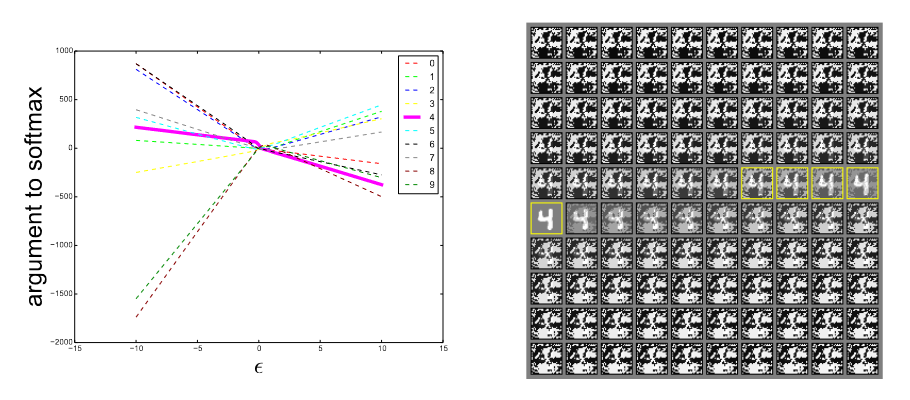

Left) A plot showing the argument to the softmax layer for each of the 10 MNIST classes as we vary $\epsilon$ on a single input example. The correct class is 4. We see that **the unnormalized log probabilities for each class are conspicuously piecewise linear with $\epsilon$ and that the wrong classifications are stable across a wide region of $\epsilon$ values**. Moreover, the predictions become very extreme as we increase $\epsilon$ enough to move into the regime of rubbish inputs. Right) The inputs used to generate the curve (upper left = negative $\epsilon$, lower right = positive $\epsilon$, yellow boxes indicate correctly classified inputs).

By tracing out different values of $\epsilon$, we can see that adversarial examples occur reliably for almost any sufficiently large value of $\epsilon$ provided that we move in the correct direction. Correct classifications occur only on a thin manifold where $x$ occurs in the data. Most of $R^{n}$ consists of adversarial examples and *rubbish class examples*. 

To explain why mutiple classifiers assign the same class to adversarial examples, we hypothesize that neural networks trained with current methodologies all resemble the linear classifier learned on the same training set. This reference classifier is able to learn approximately the same classification weights when trained on different subsets of the training set, simply because machine learning algorithms are able to generalize. **The stability of the underlying classification weights in turn results in the stability of adversarial examples.**

## ALTERNATIVE HYPOTHESES

We now consider and refute some alternative hypotheses for the existence of adversarial examples.

First, one hypothesis is that **generative training** could provide more constraint on the training process, or **cause the model to learn what to distinguish “real” from “fake” data and be confident only on “real” data**. Generative models having **differentiable** inference procedure are responding to adversarial examples, rather than the non-generative classifier model on top. We find that the models are **vulnerable** to adversarial examples in experiments. Other generative models either having non-differentiable inference procedures, making it harder to compute adversarial examples, or requiring an additional non-generative discriminator model to get good classification accuracy on MNIST. We can be sure that the generative model itself is responding to adversarial examples, rather than the non-generative classifier model on top.

Another hypothesis about why adversarial examples exist is that individual models have strange quirks but **averaging over many models can cause adversarial examples to wash out**. However, experiments suggest that ensembling provides only limited resistance to adversarial perturbation.

## SUMMARY AND DISCUSSION

- Adversarial examples can be explained as a property of high-dimensional **dot products**. They are a result of models being too linear, rather than too nonlinear.
- The generalization of adversarial examples **across different models** can be explained as a result of adversarial perturbations being highly aligned with the weight vectors of a model, and **different models learning similar functions** when trained to perform the same task.
- **The direction of perturbation**, rather than the specific point in space, matters most. Space is not full of pockets of adversarial examples that finely tile the reals like the rational numbers.
- Because it is the direction that matters most, adversarial perturbations generalize **across different clean examples**.
- We have introduced **a family of fast methods for generating adversarial examples**.
- We have demonstrated that **adversarial training can result in regularization**; even further regularization than dropout.
- We have run control experiments that failed to reproduce this effect with simpler but less efficient regularizers including L1 weight decay and adding noise.
- **Models that are easy to optimize are easy to perturb**.
- Linear models lack the capacity to resist adversarial perturbation; **only structures with a hidden layer (where the universal approximator theorem applies) should be trained to resist adversarial perturbation**.
- **RBF networks** are resistant to adversarial examples.
- Models trained to model the input distribution are not resistant to adversarial examples.
- Ensembles are not resistant to adversarial examples.

Some further observations concerning rubbish class examples are presented in the appendix:
- Rubbish class examples are **ubiquitous** and easily generated.
- Shallow linear models are not resistant to rubbish class examples.
- **RBF networks** are resistant to rubbish class examples.

**The existence of adversarial examples suggests that being able to explain the training data or even being able to correctly label the test data does not imply that our models truly understand the tasks we have asked them to perform.** Instead, their linear responses are overly confident at points that do not occur in the data distribution, and these confident predictions are often highly incorrect. This work has shown we can partially correct for this problem by explicitly identifying problematic points and correcting the model at each of these points. However, one may also conclude that the model families we use are intrinsically flawed. **Ease of optimization has come at the cost of models that are easily misled.** This motivates the development of optimization procedures that are able to train models whose behavior is **more locally stable**.


## RUBBISH CLASS EXAMPLES

A concept related to adversarial examples is the concept of examples drawn from a “rubbish class.” **These examples are degenerate inputs that a human would classify as not belonging to any of the categories in the training set.** If we call these classes in the training set “the positive classes,” then we want to be careful to avoid false positives on rubbish inputs–i.e., we do not want to classify a degenerate input as being something real. In the case of separate binary classifiers for each class, we want all classes output near zero probability of the class being present, and in the case of a multinoulli distribution over only the positive classes, we would prefer that the classifier output a high-entropy (nearly uniform) distribution over the classes. The traditional approach to reducing vulnerability to rubbish inputs is to **introduce an extra, constant output to the model representing the rubbish class**. As with adversarial examples, there has been a misconception that **rubbish class false positives are hard to find**, and that they are primarily a problem faced by deep networks.

Our explanation of adversarial examples as the result of linearity and high dimensional spaces also applies to analyzing the behavior of the model on rubbish class examples. Linear models produce more extreme predictions at points that are far from the training data than at points that are near the training data. In order to find high confidence rubbish false positives for such a model, we need only generate a point that is far from the data, with larger norms yielding more confidence. RBF networks, which are not able to confidently predict the presence of any class far from the training data, are not fooled by this phenomenon.

The problem of generating fooling images for a specific class, which is a harder problem than simply finding points that the network confidently classifies as belonging to any one class despite being defective.

To solve the problem of generating a fooling image for a particular class, we propose adding $\epsilon ∇_{x}p(y = i | x)$ to a Gaussian sample $x$ as a fast method of generating a fooling image classified as class $i$. If we repeat this sampling process until it succeeds, we a randomized algorithm with variable runtime. We can thus generate any desired class with a handful of samples and no special priors, rather than tens of thousands of generations of evolution. 

Unfortunately, unlike training on adversarial examples, this did not result in any significant reduction of the model’s test set error rate.

**In conclusion, it appears that a randomly selected input to deep or shallow models built from linear parts is overwhelmingly likely to be processed incorrectly, and that these models only behave reasonably on a very thin manifold encompassing the training data.**